# EGG CRACK DETECTION

In [85]:
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from skimage import io, color, transform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import cv2

# PREPROCESSING THE IMAGE

In [87]:
#for train
input_folder = 'C:/Users/prasa/Desktop/ml/image/train'
output_folder = 'C:/Users/prasa/Desktop/ml/pre_image_train'

os.makedirs(output_folder, exist_ok=True)

def preprocess_image(image_path, target_size=(224, 224)):
    
    
    
    img = cv2.imread(image_path)
    desired_width = 250
    desired_height = 100
    resized_image = cv2.resize(img, (desired_width, desired_height))
    
    img_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    edges = cv2.Canny(img_blur, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in contours if cv2.contourArea(contour) > 100]
    ellipses = []
    for contour in contours:
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            ellipses.append(ellipse)
    bounding_rectangles = [cv2.boundingRect(contour) for contour in contours]
    img_highlighted = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    for ellipse in ellipses:
        cv2.ellipse(img_highlighted, ellipse, (0, 255, 0), 2)
        
    cropped_images = []
    for i, rectangle in enumerate(bounding_rectangles):
        x, y, w, h = rectangle
        cropped_image = img_gray[y:y+h, x:x+w]
        cropped_images.append(cropped_image)
        cv2.rectangle(img_highlighted, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return cropped_images

for subfolder in ['0','1']:
    input_subfolder = os.path.join(input_folder, subfolder)
    output_subfolder = os.path.join(output_folder, subfolder)

    os.makedirs(output_subfolder, exist_ok=True)

    image_list = os.listdir(input_subfolder)
    for image_name in tqdm(image_list, desc=f'Processing {subfolder}'):
        input_path = os.path.join(input_subfolder, image_name)
        output_path = os.path.join(output_subfolder, image_name)

        processed_image = preprocess_image(input_path)
        for i, cropped_image in enumerate(processed_image):
            output_path = os.path.join(output_subfolder, f"{i}_{image_name}")
            cv2.imwrite(output_path, (cropped_image * 255).astype(np.uint8))


print("Image preprocessing complete.")


Processing 1: 100%|██████████| 190/190 [00:01<00:00, 105.05it/s]

Image preprocessing complete.


In [88]:
#fro test
input_folder = 'C:/Users/prasa/Desktop/ml/image/test'
output_folder = 'C:/Users/prasa/Desktop/ml/pre_image_test'

os.makedirs(output_folder, exist_ok=True)

def preprocess_image(image_path, target_size=(224, 224)):
    
    
    
    img = cv2.imread(image_path)
    desired_width = 250
    desired_height = 100
    resized_image = cv2.resize(img, (desired_width, desired_height))
    
    img_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    edges = cv2.Canny(img_blur, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in contours if cv2.contourArea(contour) > 100]
    ellipses = []
    for contour in contours:
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            ellipses.append(ellipse)
    bounding_rectangles = [cv2.boundingRect(contour) for contour in contours]
    img_highlighted = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    for ellipse in ellipses:
        cv2.ellipse(img_highlighted, ellipse, (0, 255, 0), 2)
        
    cropped_images = []
    for i, rectangle in enumerate(bounding_rectangles):
        x, y, w, h = rectangle
        cropped_image = img_gray[y:y+h, x:x+w]
        cropped_images.append(cropped_image)
        cv2.rectangle(img_highlighted, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return cropped_images

for subfolder in ['0','1']:
    input_subfolder = os.path.join(input_folder, subfolder)
    output_subfolder = os.path.join(output_folder, subfolder)

    os.makedirs(output_subfolder, exist_ok=True)

    image_list = os.listdir(input_subfolder)
    for image_name in tqdm(image_list, desc=f'Processing {subfolder}'):
        input_path = os.path.join(input_subfolder, image_name)
        output_path = os.path.join(output_subfolder, image_name)

        processed_image = preprocess_image(input_path)
        for i, cropped_image in enumerate(processed_image):
            output_path = os.path.join(output_subfolder, f"{i}_{image_name}")
            cv2.imwrite(output_path, (cropped_image * 255).astype(np.uint8))


print("Image preprocessing complete.")


Processing 1: 100%|██████████| 34/34 [00:00<00:00, 89.14it/s]

Image preprocessing complete.


# IMAGE TO CSV

In [89]:
import numpy as np
import pandas as pd
from PIL import Image
import os

In [90]:
import os
import pandas as pd
from PIL import Image

def extract_rgb_values(image_path):
    img = Image.open(image_path)
    rgb_values = list(img.getdata())
    img.close()
    return rgb_values

def create_csv(dataset_folder, csv_filename):
    data = {'label': [], 'image_path': []}

    # Add RGB columns
    max_pixels = 1024  # Maximum number of pixels per channel
    for i in range(1, max_pixels * 3 + 1):
        data[f'Pixel{i}'] = []

    for label in os.listdir(dataset_folder):
        label_folder = os.path.join(dataset_folder, label)
        if os.path.isdir(label_folder):
            for image_file in os.listdir(label_folder):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    image_path = os.path.join(label_folder, image_file)
                    data['image_path'].append(image_path)
                    data['label'].append(label)

                    rgb_values = extract_rgb_values(image_path)

                    # Ensure all arrays have the same length
                    num_pixels = min(len(rgb_values), max_pixels * 3)
                    for i in range(num_pixels):
                        data[f'Pixel{i + 1}'].append(rgb_values[i])

                    # Fill in any remaining columns with NaN
                    for i in range(num_pixels, max_pixels * 3):
                        data[f'Pixel{i + 1}'].append(None)

    df = pd.DataFrame(data)
    df.to_csv(csv_filename, index=False)
    print(f"CSV file '{csv_filename}' created successfully.")


dataset_folder = 'C:/Users/prasa/Desktop/ml/pre_image_train'
csv_filename = 'C:/Users/prasa/Desktop/ml/to_csv1_train.csv'
create_csv(dataset_folder, csv_filename)


CSV file 'C:/Users/prasa/Desktop/ml/to_csv1_train.csv' created successfully.


In [91]:
import os
import pandas as pd
from PIL import Image

def extract_rgb_values(image_path):
    img = Image.open(image_path)
    rgb_values = list(img.getdata())
    img.close()
    return rgb_values

def create_csv(dataset_folder, csv_filename):
    data = {'label': [], 'image_path': []}

    # Add RGB columns
    max_pixels = 1024  # Maximum number of pixels per channel
    for i in range(1, max_pixels * 3 + 1):
        data[f'Pixel{i}'] = []

    for label in os.listdir(dataset_folder):
        label_folder = os.path.join(dataset_folder, label)
        if os.path.isdir(label_folder):
            for image_file in os.listdir(label_folder):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    image_path = os.path.join(label_folder, image_file)
                    data['image_path'].append(image_path)
                    data['label'].append(label)

                    rgb_values = extract_rgb_values(image_path)

                    # Ensure all arrays have the same length
                    num_pixels = min(len(rgb_values), max_pixels * 3)
                    for i in range(num_pixels):
                        data[f'Pixel{i + 1}'].append(rgb_values[i])

                    # Fill in any remaining columns with NaN
                    for i in range(num_pixels, max_pixels * 3):
                        data[f'Pixel{i + 1}'].append(None)

    df = pd.DataFrame(data)
    df.to_csv(csv_filename, index=False)
    print(f"CSV file '{csv_filename}' created successfully.")


dataset_folder = 'C:/Users/prasa/Desktop/ml/pre_image_test'
csv_filename = 'C:/Users/prasa/Desktop/ml/to_csv1_test.csv'
create_csv(dataset_folder, csv_filename)


CSV file 'C:/Users/prasa/Desktop/ml/to_csv1_test.csv' created successfully.


In [92]:
import pandas as pd

df = pd.read_csv('C:/Users/prasa/Desktop/ml/to_csv1_train.csv')
df.head
df=df.fillna(0)
df

,label,image_path,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,...,Pixel3063,Pixel3064,Pixel3065,Pixel3066,Pixel3067,Pixel3068,Pixel3069,Pixel3070,Pixel3071,Pixel3072
0,0,C:/Users/prasa/Desktop/ml/pre_image_train\0\0_...,101,101,100,103,101,100,104,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,C:/Users/prasa/Desktop/ml/pre_image_train\0\0_...,106,106,105,103,103,104,103,102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,C:/Users/prasa/Desktop/ml/pre_image_train\0\0_...,105,107,107,103,108,106,102,107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,C:/Users/prasa/Desktop/ml/pre_image_train\0\0_...,104,103,103,101,100,102,103,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,C:/Users/prasa/Desktop/ml/pre_image_train\0\0_...,94,95,96,96,95,94,94,94,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1,C:/Users/prasa/Desktop/ml/pre_image_train\1\0_...,105,105,107,104,105,107,107,107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,1,C:/Users/prasa/Desktop/ml/pre_image_train\1\0_...,104,108,107,104,109,107,102,108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,1,C:/Users/prasa/Desktop/ml/pre_image_train\1\0_...,107,106,109,105,106,108,106,105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,1,C:/Users/prasa/Desktop/ml/pre_image_train\1\0_...,107,106,105,105,104,106,109,105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA ANALYSIS

PCA CSV file 'C:/Users/prasa/Desktop/ml/PCA_ANA_train.csv' saved successfully.


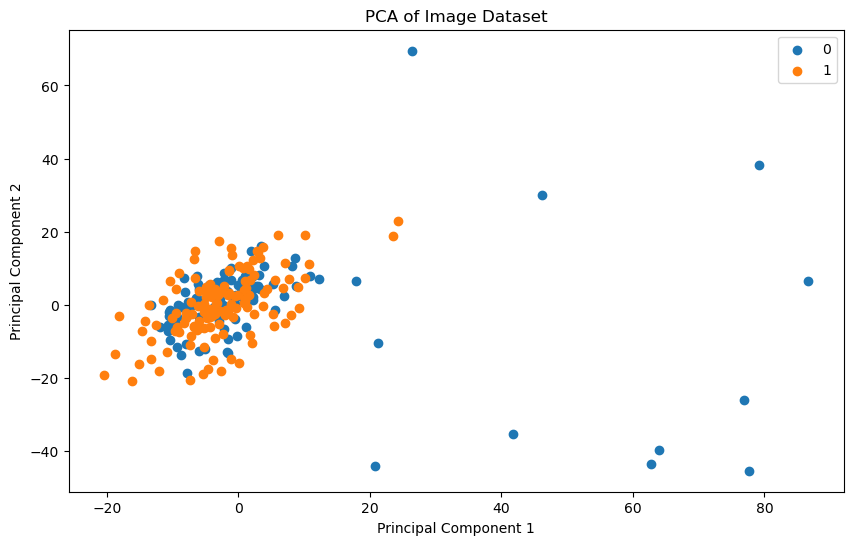

In [256]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load the dataset
csv_filename = 'C:/Users/prasa/Desktop/ml/to_csv1_train.csv'
df = pd.read_csv(csv_filename)

# Separate features (RGB values) and labels
X = df.drop(['label', 'image_path'], axis=1)
y = df['label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)

# Apply PCA best value =7
n_components = 2 # You can adjust the number of components based on your needs
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_imputed)

# Create a DataFrame with the principal components
columns = [f'PC{i + 1}' for i in range(n_components)]
pc_df = pd.DataFrame(data=principal_components, columns=columns)
pc_df['label'] = y

# Save the new DataFrame with principal components as a new CSV file
output_csv_filename = 'C:/Users/prasa/Desktop/ml/PCA_ANA_train.csv'
pc_df.to_csv(output_csv_filename, index=False)
print(f"PCA CSV file '{output_csv_filename}' saved successfully.")

# Visualize the results (scatter plot)
plt.figure(figsize=(10, 6))
for label in pc_df['label'].unique():
    subset = pc_df[pc_df['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'],label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Image Dataset')
plt.legend()
plt.show()


In [257]:
data = pd.read_csv('C:/Users/prasa/Desktop/ml/PCA_ANA_train.csv')
data

,PC1,PC2,label
0,10.961200,7.943248,0
1,12.251024,7.150918,0
2,8.824075,5.182952,0
3,-5.082729,-12.027368,0
4,8.112318,10.743073,0
...,...,...,...
244,-3.574811,-2.607725,1
245,-3.867549,-15.177549,1
246,-13.533311,0.005981,1
247,-9.329291,-6.130423,1


C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


PCA CSV file 'C:/Users/prasa/Desktop/ml/PCA_ANA_test.csv' saved successfully.


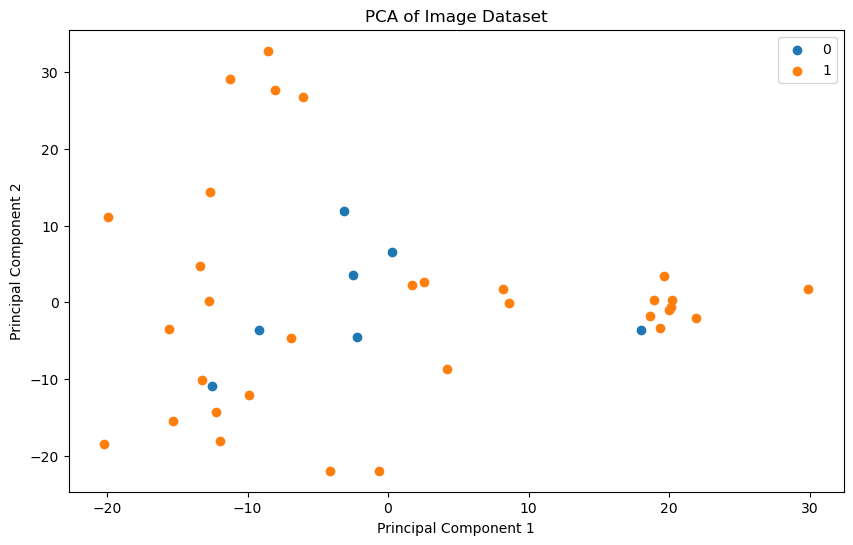

In [258]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Load the dataset
csv_filename = 'C:/Users/prasa/Desktop/ml/to_csv1_test.csv'
df = pd.read_csv(csv_filename)

# Separate features (RGB values) and labels
X = df.drop(['label', 'image_path'], axis=1)
y = df['label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)

# Apply PCA best value =7
n_components = 2 # You can adjust the number of components based on your needs
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_imputed)

# Create a DataFrame with the principal components
columns = [f'PC{i + 1}' for i in range(n_components)]
pc_df = pd.DataFrame(data=principal_components, columns=columns)
pc_df['label'] = y

# Save the new DataFrame with principal components as a new CSV file
output_csv_filename = 'C:/Users/prasa/Desktop/ml/PCA_ANA_test.csv'
pc_df.to_csv(output_csv_filename, index=False)
print(f"PCA CSV file '{output_csv_filename}' saved successfully.")

# Visualize the results (scatter plot)
plt.figure(figsize=(10, 6))
for label in pc_df['label'].unique():
    subset = pc_df[pc_df['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'],label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Image Dataset')
plt.legend()
plt.show()


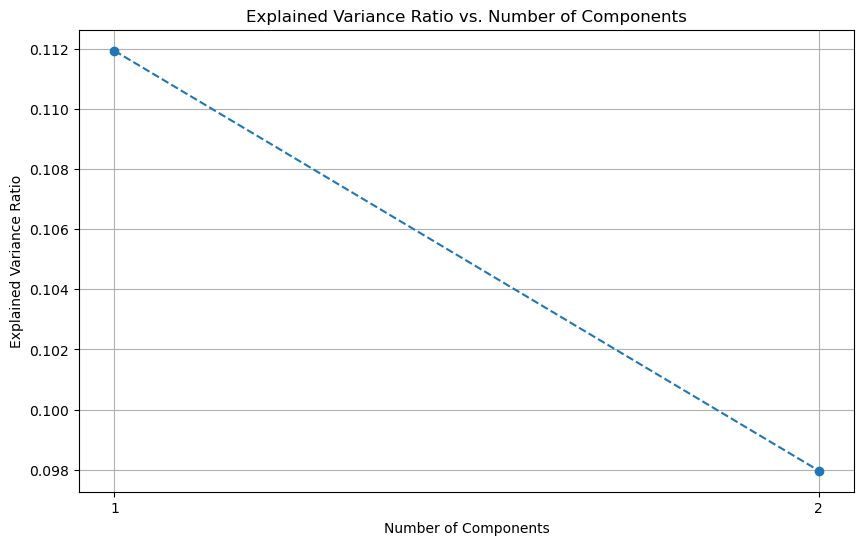

In [259]:
# Get explained variance ratio
explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.xticks(range(1, len(explained_var) + 1))
plt.grid(True)
plt.show()

# TRAIN AND TEST DATASET

In [322]:
data_train = pd.read_csv('C:/Users/prasa/Desktop/ml/PCA_ANA_train.csv')
X_train = data_train[['PC1', 'PC2']]
y_train = data_train['label']

data_test = pd.read_csv('C:/Users/prasa/Desktop/ml/PCA_ANA_test.csv')
X_test = data_test[['PC1', 'PC2']]
y_test = data_test['label']

# GAUSSIAN MIXTURE MODELS ANALYSIS

In [323]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report
import os
os.environ["OMP_NUM_THREADS"] = "1"
n_components = 2 
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train)
y_pred1 = gmm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred1)
classification_rep = classification_report(y_test, y_pred1)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.48717948717948717
Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.14      0.09         7
           1       0.75      0.56      0.64        32

    accuracy                           0.49        39
   macro avg       0.41      0.35      0.37        39
weighted avg       0.63      0.49      0.54        39



C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


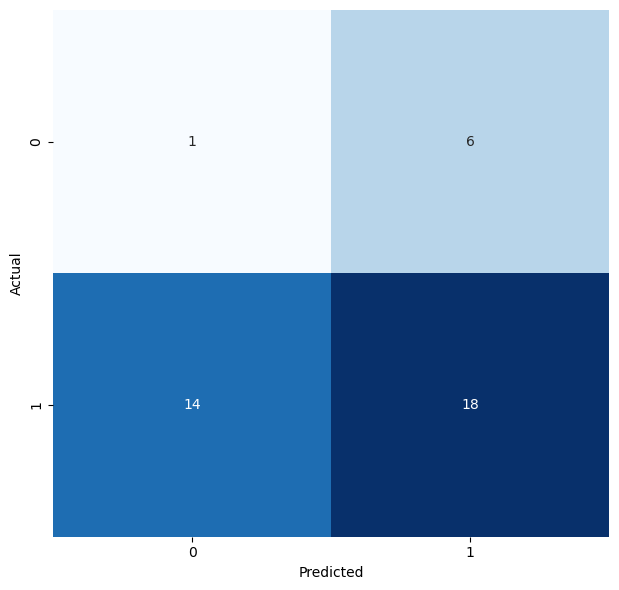

In [324]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
GMM = confusion_matrix(y_test, y_pred1)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(GMM, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


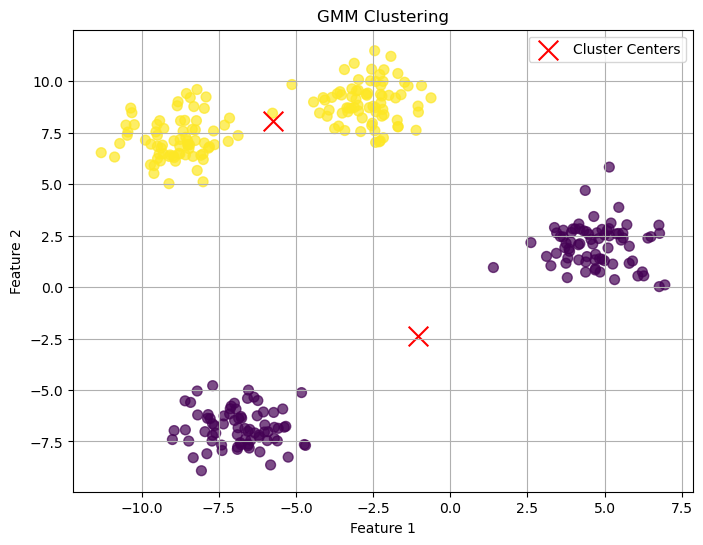

In [325]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
X=X_train
y=y_train
# Create synthetic dataset
X, y = make_blobs(n_samples=300, centers=4, random_state=42)

# Fit GMM model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# Predict clusters
labels = gmm.predict(X)

# Plotting clusters and centroids
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=200, marker='x', label='Cluster Centers')
plt.title('GMM Clustering')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


# NAIVE BAYES ANALYSIS

In [326]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Initialize Naive Bayes classifier
naive_bayes_classifier = GaussianNB()

# Train the classifier
naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred2 = naive_bayes_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred2)
classification_rep = classification_report(y_test, y_pred2)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_mat)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.358974358974359
Confusion Matrix:
[[ 1  6]
 [19 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.14      0.07         7
           1       0.68      0.41      0.51        32

    accuracy                           0.36        39
   macro avg       0.37      0.27      0.29        39
weighted avg       0.57      0.36      0.43        39



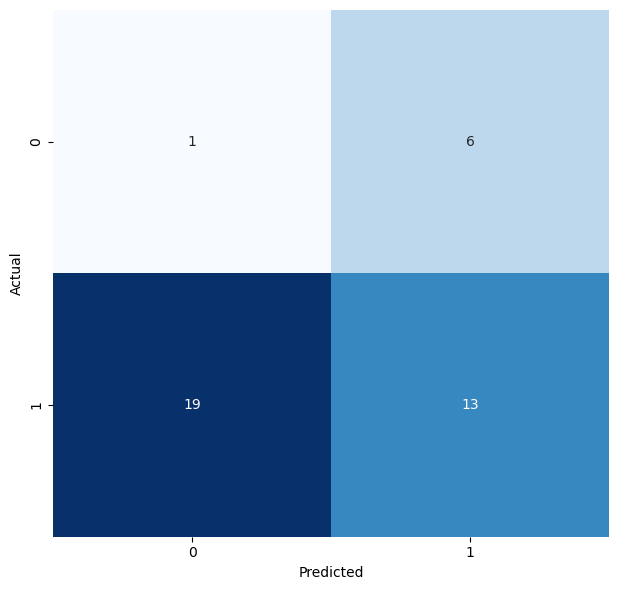

In [327]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
GMM = confusion_matrix(y_test, y_pred2)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(GMM, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# XGBOOST ANALYSIS

In [328]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier  # Import XGBoost classifier


# Base Models (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Base Models (Boosting)
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Base Models (Stacking)
dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier(n_neighbors=3)

# Stacking Meta-Model (using XGBoost)
xgboost_meta_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)  # Adjust parameters as needed

# Create an ensemble using Voting (Bagging and Boosting)
bagging_boosting_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('adaboost', adaboost_model)
    ],
    voting='soft'
)

# Create an ensemble using Stacking
stacking_ensemble = StackingClassifier(
    estimators=[
        ('dt', dt_model),
        ('knn', knn_model)
    ],
    final_estimator=xgboost_meta_model,  # Use XGBoost as the meta-model
    stack_method='auto',
    passthrough=True
)

# Train Bagging and Boosting Ensemble
bagging_boosting_ensemble.fit(X_train, y_train)

# Train Stacking Ensemble
stacking_ensemble.fit(X_train, y_train)

# Make Predictions
bagging_boosting_predictions = bagging_boosting_ensemble.predict(X_test)
stacking_predictions = stacking_ensemble.predict(X_test)

# Evaluate Ensembles
bagging_boosting_accuracy = accuracy_score(y_test, bagging_boosting_predictions)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)

print(f"Bagging and Boosting Ensemble Accuracy: {bagging_boosting_accuracy}")
print(f"Stacking Ensemble Accuracy with XGBoost: {stacking_accuracy}")


Bagging and Boosting Ensemble Accuracy: 0.5641025641025641
Stacking Ensemble Accuracy with XGBoost: 0.7948717948717948


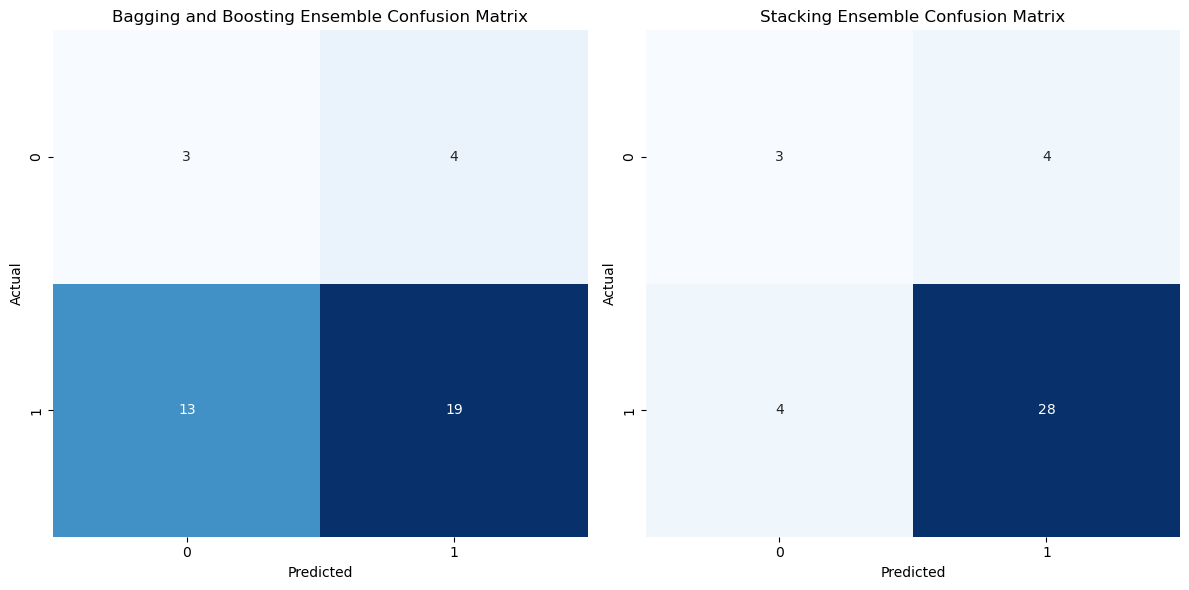

In [329]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
bagging_boosting_conf_matrix = confusion_matrix(y_test, bagging_boosting_predictions)
stacking_conf_matrix = confusion_matrix(y_test, stacking_predictions)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(bagging_boosting_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Bagging and Boosting Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(stacking_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Stacking Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


# DBSCAN CLUSTERING

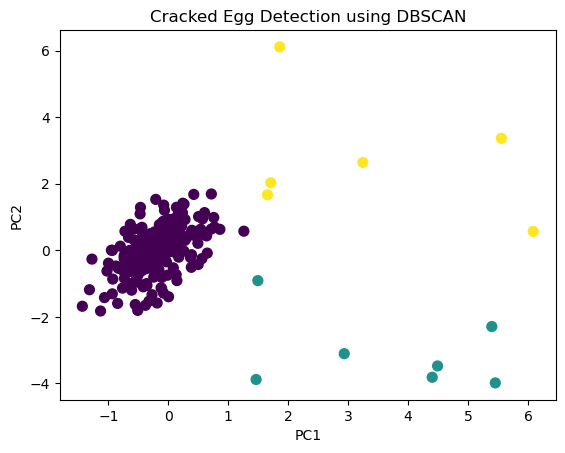

Best Parameters: Epsilon = 0.5 , Min Samples = 3
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.10      0.18       112
           1       0.57      0.99      0.72       137

    accuracy                           0.59       249
   macro avg       0.71      0.54      0.45       249
weighted avg       0.70      0.59      0.48       249



In [364]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


# Extract features (excluding labels)
features = data_train.drop('label', axis=1)
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Apply DBSCAN
eps_values = [0.3, 0.5, 0.7]  # Adjust as needed
min_samples_values = [3, 5, 7]  # Adjust as needed

best_eps, best_min_samples, best_score = None, None, 0

for eps_value in eps_values:
    for min_samples_value in min_samples_values:
        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        clusters = dbscan.fit_predict(features)
        
        # Calculate silhouette score (you can use other metrics as well)
        silhouette_score = np.mean(np.where(clusters != -1, 1, 0))
        
        if silhouette_score > best_score:
            best_score = silhouette_score
            best_eps, best_min_samples = eps_value, min_samples_value


# Re-run DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(features)

# Add cluster labels to the original data
data_train['Cluster'] = clusters

# Adjust the prediction rule for cracked egg detection
def predict_cracked_label(cluster_labels):
    # If the majority of the cluster is labeled as 0 (cracked), classify the cluster as cracked
    if (cluster_labels == 0).sum() > len(cluster_labels) / 2:
        return 0  # Cracked
    else:
        return 1  # Not cracked

data_train['Predicted_Label'] = data_train.groupby('Cluster')['label'].transform(predict_cracked_label)

# Visualize the clusters (2D PCA)
plt.scatter(features[:, 0], features[:, 1], c=data_train['label'], cmap='viridis', s=50)
plt.title('Cracked Egg Detection using DBSCAN')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Evaluate performance
print("Best Parameters: Epsilon =", best_eps, ", Min Samples =", best_min_samples)
print("Classification Report:\n", classification_report(data['label'], data['Predicted_Label']))


In [339]:
print(silhouette_score)

0.9477911646586346


# HIERARCHICAL CLUSTERING

In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
model_no_pca = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_no_pca = model_no_pca.fit_predict(features)

C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


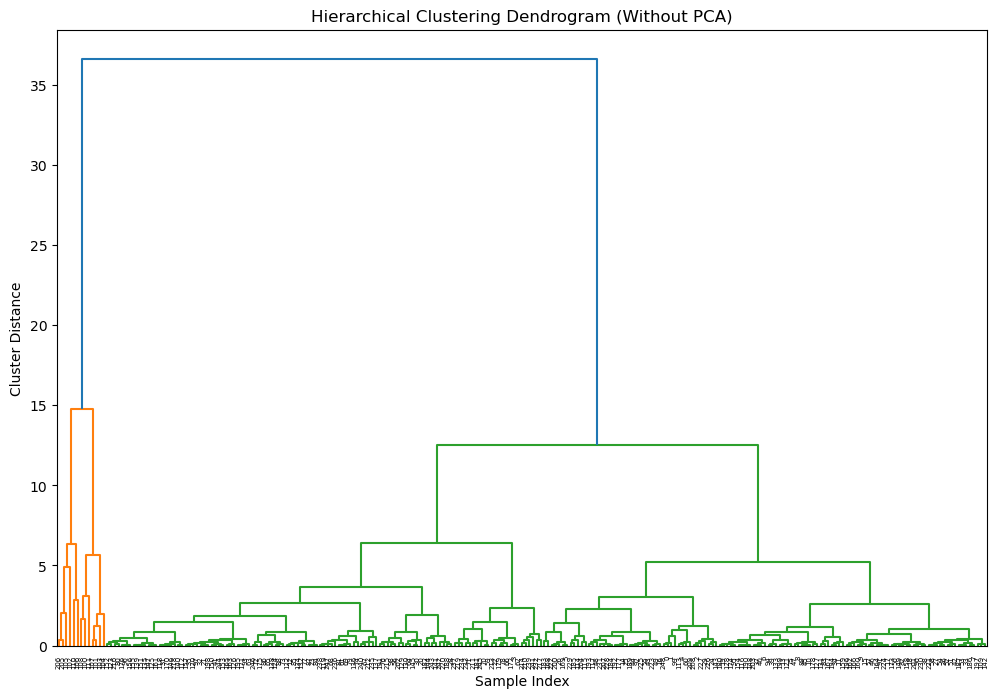

In [344]:
linked_no_pca = linkage(features, 'ward')
plt.figure(figsize=(12, 8))
dendrogram(linked_no_pca,
           orientation='top',
           labels=list(range(len(features))),
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Without PCA)')
plt.xlabel('Sample Index')
plt.ylabel('Cluster Distance')
plt.show()

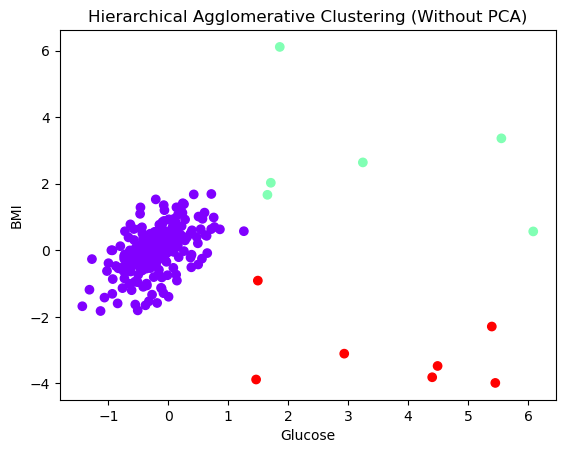

In [345]:
plt.scatter(features[:, 0], features[:, 1], c=clusters_no_pca, cmap='rainbow')
plt.title('Hierarchical Agglomerative Clustering (Without PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# K MEANS CLUSTERING

In [347]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

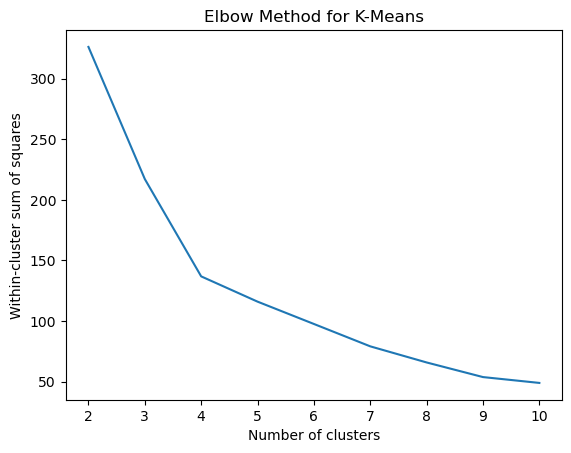

Optimal number of clusters: 3


In [351]:
k_min = 2
k_max = 10
wcss = []
for k in range(k_min, k_max + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)
plt.plot(range(k_min, k_max + 1), wcss)
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster sum of squares")
plt.title("Elbow Method for K-Means")
plt.show()
elbow_point = None
for i in range(1, len(wcss)):
    if wcss[i-1] - wcss[i] > wcss[i+1] - wcss[i]:
        elbow_point = i + k_min
        break
optimal_k = elbow_point
print(f"Optimal number of clusters: {optimal_k}")

C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


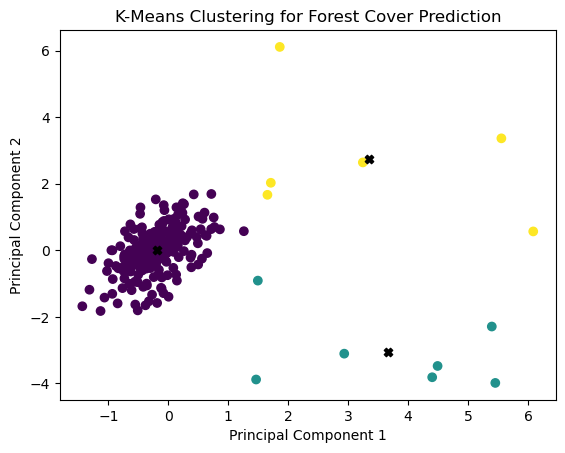

In [356]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features)
data_train['label'] = kmeans.labels_
plt.scatter(features[:, 0], features[:, 1], c=data_train['label'], cmap='viridis')
plt.title('K-Means Clustering for Forest Cover Prediction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X')
plt.show()